<a href="https://colab.research.google.com/github/meximized/eye_pathology_detection/blob/main/CV_lab_basics(with_plots).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Colab_Notebooks/Eye_images/

/content/drive/MyDrive/Colab_Notebooks/Eye_images


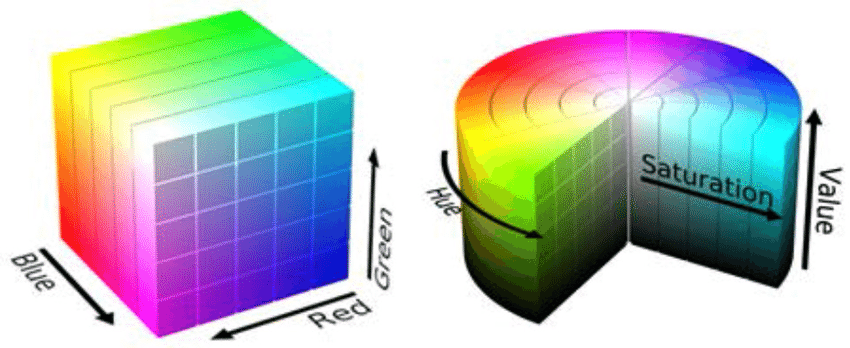

ОРИЕНТИРУЕМСЯ ДЕЛЯ ЗНАЧЕНИЕ ДЛЯ НАШЕГО ЦВЕТА НА 2

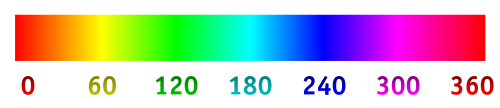

* Hue — цветовой тон, (например, красный, зелёный или сине-голубой). Варьируется в пределах 0—360°, однако иногда приводится к диапазону 0—100 или 0—1. **ЗДЕСЬ В ПРЕДЕЛАХ 0-179**
* Saturation — насыщенность. Варьируется в пределах 0—100 или 0—1. Чем больше этот параметр, тем «чище» цвет, поэтому этот параметр иногда называют чистотой цвета. А чем ближе этот параметр к нулю, тем ближе цвет к нейтральному серому. **ЗДЕСЬ В ПРЕДЕЛАХ 0-255**
* Value (значение цвета) или Brightness — яркость. Также задаётся в пределах 0—100 или 0—1. **ЗДЕСЬ В ПРЕДЕЛАХ 0-255**

У нас есть .png изображение, это трехмерный нумпай массив (число строк, число столбцов, число каналов). Число каналов в этом расширении = 4, первые три отвечают за rgb составляющие цвета, последний канал отвечает за прозрачность (0 - полностью прозрачный пиксель, 255 - полностью непрозрачный). В предыдущей функции imconvert мы отделяем метки патологий от других пикселей на изображении глазного дна так, что метки становятся единственными непрозрачными пикселями на изображениях. В следующей функции count_pixels мы считаем количество пикселей на метках с помощью подсчета непрозрачных пикселей на альфа-канале изображения. Все пиксели делим на 4 группы TP, TN, FP, FN. Дальше мы группируем эти измерения в метрики. 

Функция получает на вход исходное изображение, с которым необходимо сравнивать все остальные изображения и словарь с оставшимися искаженными изображениями детекции патологий.

Изначально мы обрабатываем альфа-канал исходного изображения и подсчитываем число пикселей на картине неискаженной детекции.

Далее мы начинаем обрабатывать искаженные изображения через маскирование и комбинации с исходным изображением:

1) False Negatives:

Берем искаженную картинку детекции и инвертируем ее, делая прозрачной только саму область детекции, а все остальные пиксели непрозрачными - это маска.
Далее мы накладываем эту маску на исходное изображение детекции. Маска у нас необычная, в данном случае прозрачные пиксели соответствующие искаженной детекции в маске представляются черными, то есть они отображают ту область, которая не отобразится на нашем исходном изображении. А отобразятся на нем только те **пиксели, которые мы не нашли на искаженной картинке, а должны были.**

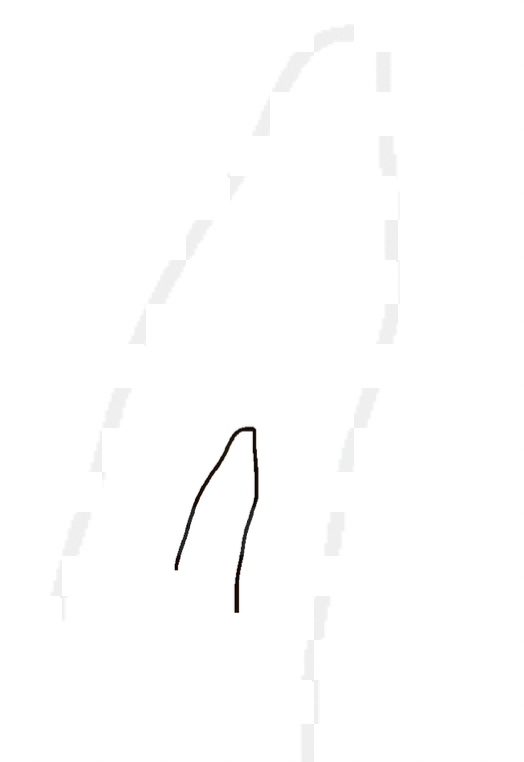

2) True Positives:

Мы берем False Negatives в качестве маски и применяем ее к исходному изображению, таким образом мы получаем те пиксели из изображения исходной детекции, которые мы правильно характеризовали как патологические с помощью детекции на искаженном изображении.

3) False Positives:

Здесь мы повторяем ту же схему, которую мы проводили в пункте 1, только меняем исходное изображение на изоблражение из массива и наоборот.

4) True Negatives:

Этих пикселей всегда будет очень много, надо как-то продумать этот момент. Для начала необходио удалить все черные пиксели за пределами изображения глазного дна, затем убрать пиксели, соответствующие картине детекции на исходном изображении. Это будет исходная картина, которая будет обрабатываться для каждого изображения искаженной детекции из массива. Так, мы удаляем все пиксели, соответствующие детекции на искаженном изображении, с этой нашей заготовки, и получаем все пиксели, которые правильно не задетектировались на искаженных картинках. (Надо подумать как быть с размытием границ на искаженных изображениях)

green - h: (77)100-102(103) degr; s: (96)98-100%; v: (62)80-81(83)%

pinkred - h: 346-349,5(357); s: (80)90-95(97)%; v: (83)91-100%

greywhite - h: 21-30 s: 13-19(27)(30)% v: (87)92-100%

yellow - h: 45 - это макула (41)51-59 s: (95)98-100% v: (90)96-100% 


In [4]:
def imconvert(image, show, *, filename = 0, background = 0, colour = 'test'): #сделать возможность использовать функцию в разных mode (background/colour)
  
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  if background == 1:
    
    background_pixels = 0

    lower_edge = np.array([0, 0, 0])
    upper_edge = np.array([179, 255, 25])

    back_mask = cv2.inRange(hsv, lower_edge, upper_edge)
    background = cv2.bitwise_and(image, image, mask = back_mask)

    background_alpha_channel = background[:,:,3]

    for i in range(background_alpha_channel.shape[0]): 
      for j in range(background_alpha_channel.shape[1]): 
        if background_alpha_channel[i][j] != 0:
          background_pixels += 1
    
    if show != 0:

      cv2_imshow(background)

    if filename != 0:

      cv2.imwrite(filename, background)

    return background_pixels
  

  if colour == 'test':
    lower_edge = np.array([60, 0, 100]) #последним значением высекаем шум
    upper_edge = np.array([60, 255, 255])

  elif colour == 'yellow':
    lower_edge = np.array([20.5, 242.25, 229.5])
    upper_edge = np.array([29.5, 255, 255])

  elif colour == 'green':
    lower_edge = np.array([38.5, 244, 158.1])
    upper_edge = np.array([51.5, 255, 212])

  elif colour == 'grey':
    lower_edge = np.array([10.5, 33.15, 221.85])
    upper_edge = np.array([15, 76.5, 255])

  elif colour == 'red':
    lower_edge = np.array([173, 204, 211.65])
    upper_edge = np.array([175.8, 247.35, 255])

  else: return "colour mode needed"

  mask = cv2.inRange(hsv, lower_edge, upper_edge)
  result = cv2.bitwise_and(image, image, mask = mask)

  mask2 = cv2.bitwise_not(mask)
  test_for_masking = cv2.bitwise_and(image, image, mask = mask2)

  if show != 0:
    cv2_imshow(image)
 #   cv2_imshow(mask)
    cv2_imshow(result)
    cv2_imshow(test_for_masking)

  if filename != 0:

    cv2.imwrite(filename, result)

  return

Изображения искаженные астигматизмом, каждая последующая цифра отображает усиление искажения на -0.3 дптр: 1 = -0.3, 2 = -0.6...

In [13]:
origin = cv2.imread('Z3/5t.png', cv2.IMREAD_UNCHANGED)

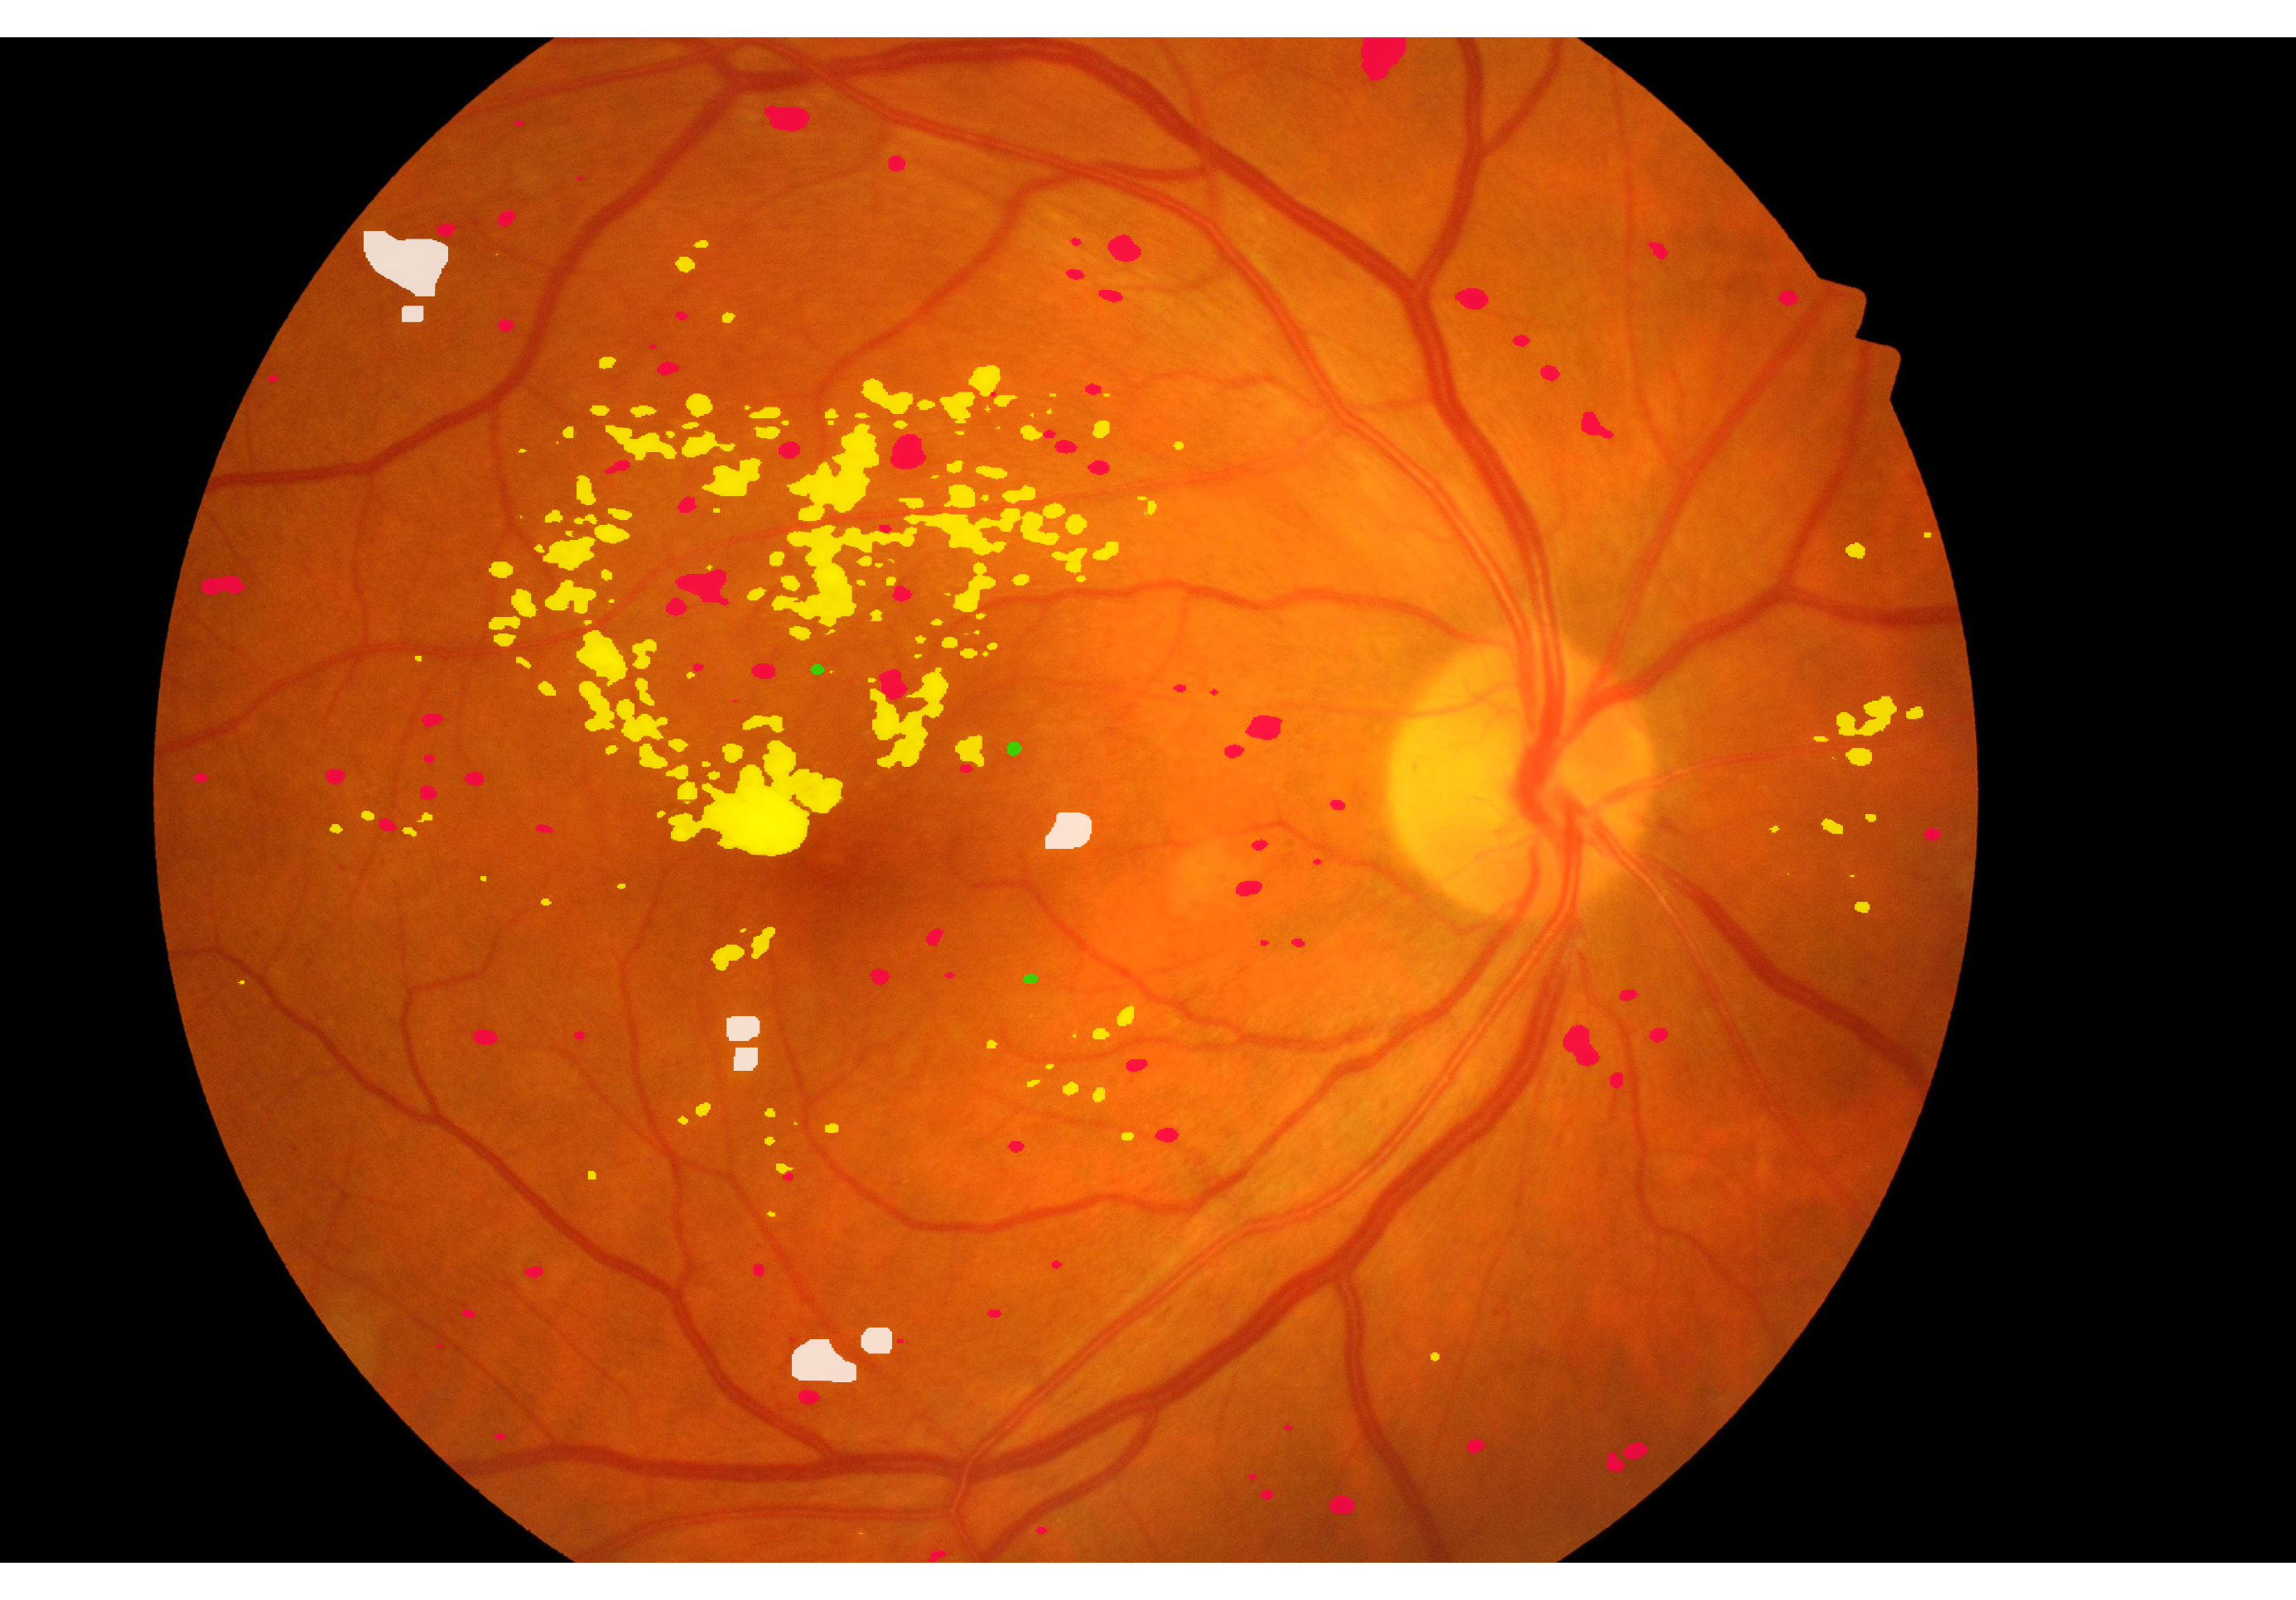

In [14]:
cv2_imshow(origin)

(1932, 2772, 4) Pixels =  5355504

In [4]:
colours = ['green', 'yellow', 'red', 'grey']

In [15]:
colours = ['green', 'yellow', 'red', 'grey']

for i in range(len(colours)):
  imconvert(origin, 0, filename = 'Z3/origin_labels_{0}.png'.format(colours[i]), colour = colours[i])

In [16]:
orig_sorted_labels = dict()
for i in range(len(colours)):
  orig_sorted_labels[colours[i]] = cv2.imread('Z3/origin_labels_{0}.png'.format(colours[i]), cv2.IMREAD_UNCHANGED)

In [17]:
#читаем исходные искаженные изображения
names = ['-03', '-06', '-09', '-12', '-15', '-18', '-21', '-24', '-27', '-30']

images = []

for i in range(len(names)):
  images.append('image_{0}'.format(i))

i = 0 
for name in names:
  images[i] = cv2.imread('Z3/' + name + '.png', cv2.IMREAD_UNCHANGED)
  i += 1

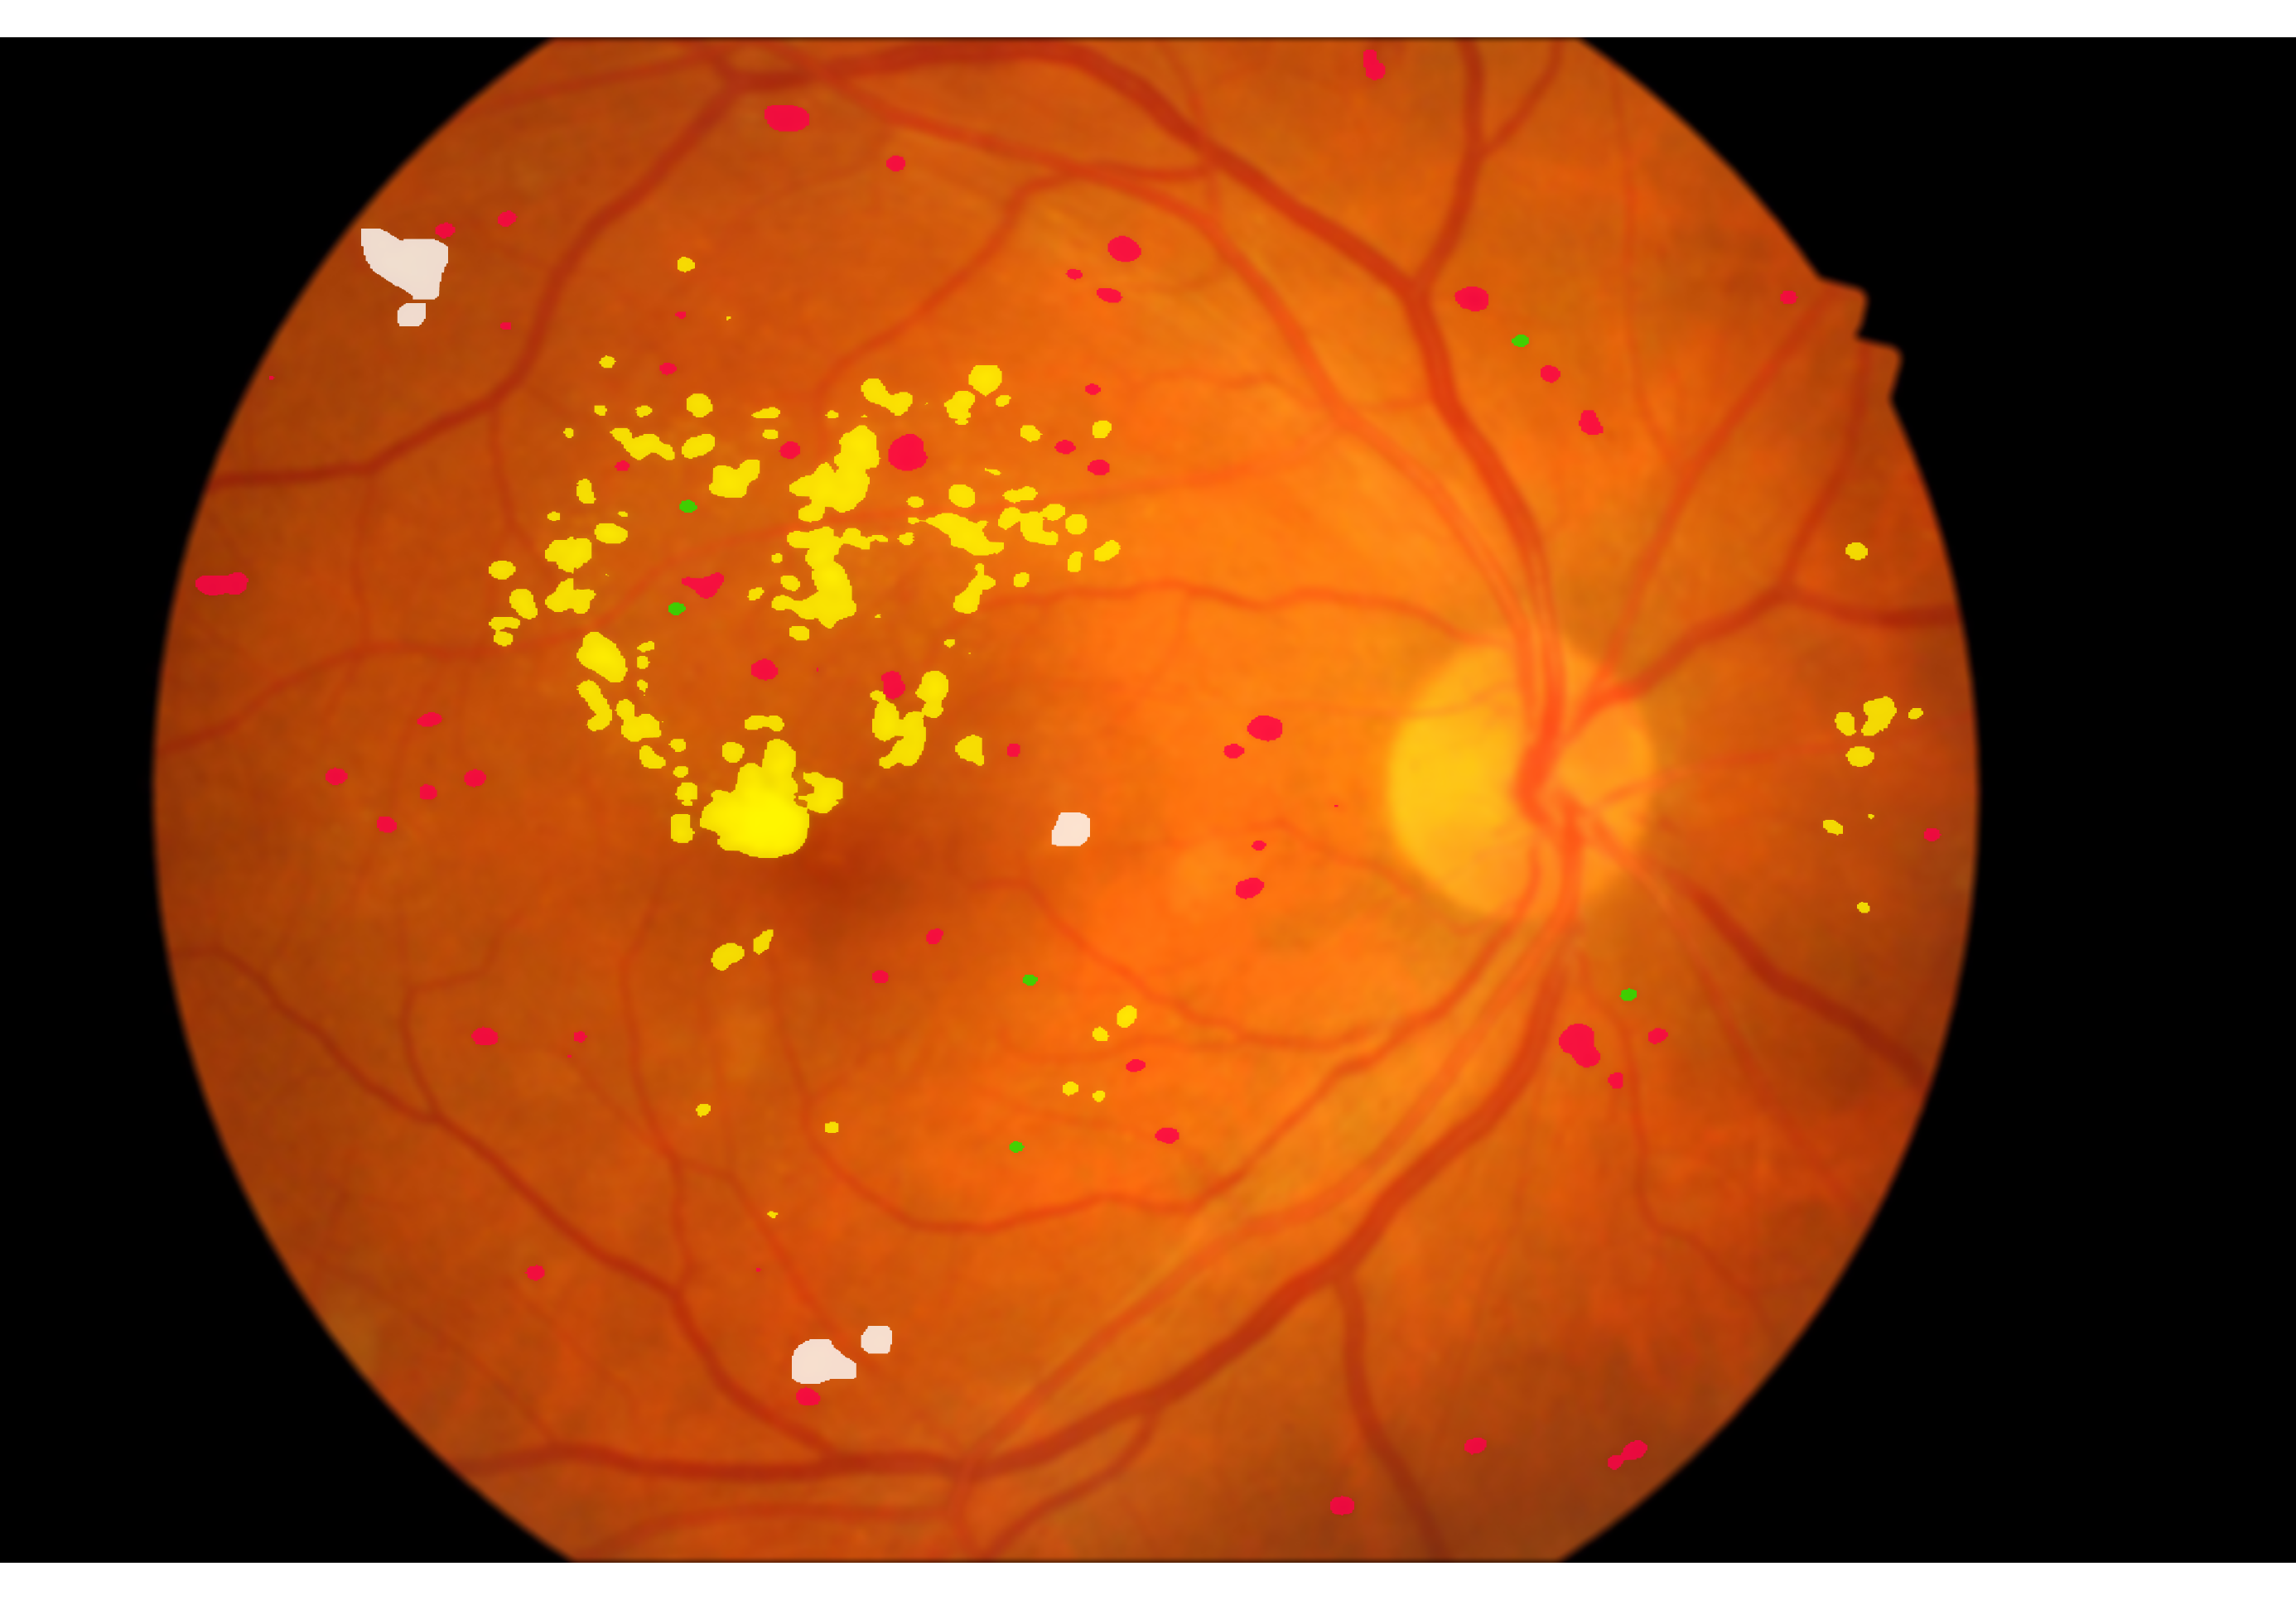

In [159]:
cv2_imshow(images[3])

In [18]:
#выделяем из этих изображений разноцветные метки и сохраняем их в отдельные файлы
for i in range(len(images)):
  for j in range(len(colours)):
    imconvert(images[i], 0, filename = "Z3/image{0}dptr_{1}_labels.png".format(names[i], colours[j]), colour = colours[j])

In [19]:
#читаем файлы с метками и сохраняем их в словарь из списков по цветам: красный - 10 изображений, итд
sorted_labels = dict()
for i in range(len(colours)):
  labels = []
  for j in range(len(images)):
    labels.append(cv2.imread("Z3/image{0}dptr_{1}_labels.png".format(names[j], colours[i]), cv2.IMREAD_UNCHANGED))
  sorted_labels[colours[i]] = labels

In [6]:
def count_pixels(orig_image, label_colours, reference_labels, labels, *, filename = 0):

  from tqdm import tqdm

  rows = orig_image.shape[0] #потом для оптимизации работы можно эти значения вставить во все циклы где используется .shape так как везде размерности одинаковые
  cols = orig_image.shape[1]

  background_pixels = imconvert(orig_image, 0, background = 1)

  total_pixels = rows * cols

  a = 0
  reference_label_alpha_channel = dict()
  reference_label_pixels = dict()

  for value in reference_labels.values():

    reference_label_alpha_channel[label_colours[a]] = value[:,:,3]

    reference_label_pixels[label_colours[a]] = 0

    for i in range(reference_label_alpha_channel[label_colours[a]].shape[0]): 
      for j in range(reference_label_alpha_channel[label_colours[a]].shape[1]): 
          if reference_label_alpha_channel[label_colours[a]][i][j] != 0:
            reference_label_pixels[label_colours[a]] += 1
   
    a += 1

#  cv2_imshow(reference_labels)
  colour_of_distorted_image_label = dict()

  for l in tqdm(range(len(label_colours))):

    distorted_image_labels = []

    for i in range(len(labels[label_colours[l]])):

      distorted_image_labels_parameters = dict()

      #FALSE NEGATIVES
      FN_mask = cv2.bitwise_not(labels[label_colours[l]][i])                # вычисляем изображение, обратное картине искаженной детекции
      FN_4_channels = cv2.bitwise_and(reference_labels[label_colours[l]], FN_mask)  # FN_4_channels вычисляем след картины искаженной детекции на картине детекции без искажений

      FN_alpha = FN_4_channels[:,:,3]
      FN_pixels = 0
      for j in range(FN_alpha.shape[0]): 
        for k in range(FN_alpha.shape[1]): 
          if FN_alpha[j][k] != 0:
            FN_pixels += 1
      distorted_image_labels_parameters['FN'] = FN_pixels

      #TRUE POSITIVES
      TP_mask = cv2.bitwise_not(FN_4_channels)              # теперь в качестве маски выступают пиксели, которые остались от оригинального изображения после того, как все остальные были убраны наложением искаженного
      TP_4_channels = cv2.bitwise_and(reference_labels[label_colours[l]], TP_mask)  # TP_4_channels получаем только те пиксели, которые совпадают у исходного изображения и искаженного
  
      TP_alpha = TP_4_channels[:,:,3]
      TP_pixels = 0
      for j in range(TP_alpha.shape[0]): 
        for k in range(TP_alpha.shape[1]): 
          if TP_alpha[j][k] != 0:
            TP_pixels += 1
      distorted_image_labels_parameters['TP'] = TP_pixels

      #FALSE POSITIVES
      FP_mask = cv2.bitwise_not(reference_labels[label_colours[l]])
      FP_4_channels = cv2.bitwise_and(labels[label_colours[l]][i], FP_mask)

      FP_alpha = FP_4_channels[:,:,3]
      FP_pixels = 0
      for j in range(FP_alpha.shape[0]): 
        for k in range(FP_alpha.shape[1]): 
          if FP_alpha[j][k] != 0:
            FP_pixels += 1
      distorted_image_labels_parameters['FP'] = FP_pixels

      #TRUE NEGATIVES
      TN_pixels = total_pixels - background_pixels - FP_pixels - TP_pixels - FN_pixels
      distorted_image_labels_parameters['TN'] = TN_pixels

      #metrics
      if (TP_pixels + FP_pixels) != 0:
        distorted_image_labels_parameters['Precision'] = TP_pixels / (TP_pixels + FP_pixels)
      else:
        distorted_image_labels_parameters['Precision'] = -0.1
      if (TP_pixels + FN_pixels) != 0:
        distorted_image_labels_parameters['Recall'] = TP_pixels / (TP_pixels + FN_pixels)
      else:
        distorted_image_labels_parameters['Recall'] = -0.1
      if (TN_pixels + FP_pixels) != 0:
        distorted_image_labels_parameters['Specificity'] = TN_pixels / (TN_pixels + FP_pixels)
      else:
        distorted_image_labels_parameters['Specificity'] = -0.1

      distorted_image_labels_parameters['Registered_pixels'] = TP_pixels + FP_pixels

      distorted_image_labels_parameters['Reference_pixels'] = reference_label_pixels[label_colours[l]]

      distorted_image_labels_parameters['Name'] = 'image_({0}dptr)_{1}'.format(round(-0.3 * (i + 1), 1), label_colours[l])

      distorted_image_labels.append(distorted_image_labels_parameters) #добавляем словарь с информацией о пикселях в общи   массив

    colour_of_distorted_image_label[label_colours[l]] = distorted_image_labels

#  correlation = []
  
#  for image in distorted_image_labels:
#    if image['TP'] != 0:
#      correlation.append(round(image['TP']/reference_label_pixels, 4))
#    else:
#      correlation.append(-1)

#  print('Reference label pixel number = ', reference_label_pixels,'\n')


  for key, value in colour_of_distorted_image_label.items():

    print('Colour of the label:', key)
    print('Number of pixels in reference label:', reference_label_pixels[key])
    print('Distorted labels pixels parameters:', '\n')
    
    for i in range(len(value)):

      print('{0}:'.format(value[i]['Name']), '\t', 
            'TP:', value[i]['TP'], '\t', 
            'FN:', value[i]['FN'], '\t', 
            'FP:', value[i]['FP'], '\t', 
            'TN:', value[i]['TN'], '\n', '\t', 
            'Precision:', round(value[i]['Precision'], 4), '\t', 
            'Recall:', round(value[i]['Recall'], 4), '\t',
            'Registered pixels:', value[i]['Registered_pixels'], '\t', 
            'Reference pixels:', value[i]['Reference_pixels'], '\t',
            'Specificity', round(value[i]['Specificity'], 4), '\n')

  print('Background pixel number:', background_pixels)
  print('Total pixel number:', total_pixels)

  if filename != 0:
    import json
    json.dump(colour_of_distorted_image_label, open('Z3/' + filename + '.json', 'w'))
  
  return colour_of_distorted_image_label

In [148]:
%%time
resulting_parameters = count_pixels(origin, colours, orig_sorted_labels, sorted_labels, filename = 'resulting_parameters')

100%|██████████| 4/4 [20:15<00:00, 303.82s/it]

Colour of the label: green
Number of pixels in reference label: 593
Distorted labels pixels parameters: 

image_(-0.3dptr)_green: 	 TP: 428 	 FN: 165 	 FP: 268 	 TN: 3774399 
 	 Precision: 0.6149 	 Recall: 0.7218 	 Registered pixels: 696 	 Reference pixels: 593 	 Specificity 0.9999 

image_(-0.6dptr)_green: 	 TP: 185 	 FN: 408 	 FP: 446 	 TN: 3774221 
 	 Precision: 0.2932 	 Recall: 0.312 	 Registered pixels: 631 	 Reference pixels: 593 	 Specificity 0.9999 

image_(-0.9dptr)_green: 	 TP: 0 	 FN: 593 	 FP: 414 	 TN: 3774253 
 	 Precision: 0.0 	 Recall: 0.0 	 Registered pixels: 414 	 Reference pixels: 593 	 Specificity 0.9999 

image_(-1.2dptr)_green: 	 TP: 166 	 FN: 427 	 FP: 1155 	 TN: 3773512 
 	 Precision: 0.1257 	 Recall: 0.2799 	 Registered pixels: 1321 	 Reference pixels: 593 	 Specificity 0.9997 

image_(-1.5dptr)_green: 	 TP: 0 	 FN: 593 	 FP: 842 	 TN: 3773825 
 	 Precision: 0.0 	 Recall: 0.0 	 Registered pixels: 842 	 Reference pixels: 593 	 Specificity 0.9998 

image_(-1.8dpt

CPU times: user 19.4 s, sys: 37.6 ms, total: 19.5 s


In [5]:
import json

data = json.load(open('Z3/resulting_parameters.json'))

In [7]:
im_names = []
for i in range(len(data['green'])):
  im_names.append('-{0}_dptr'.format(round(0.3 * (i + 1), 1)))

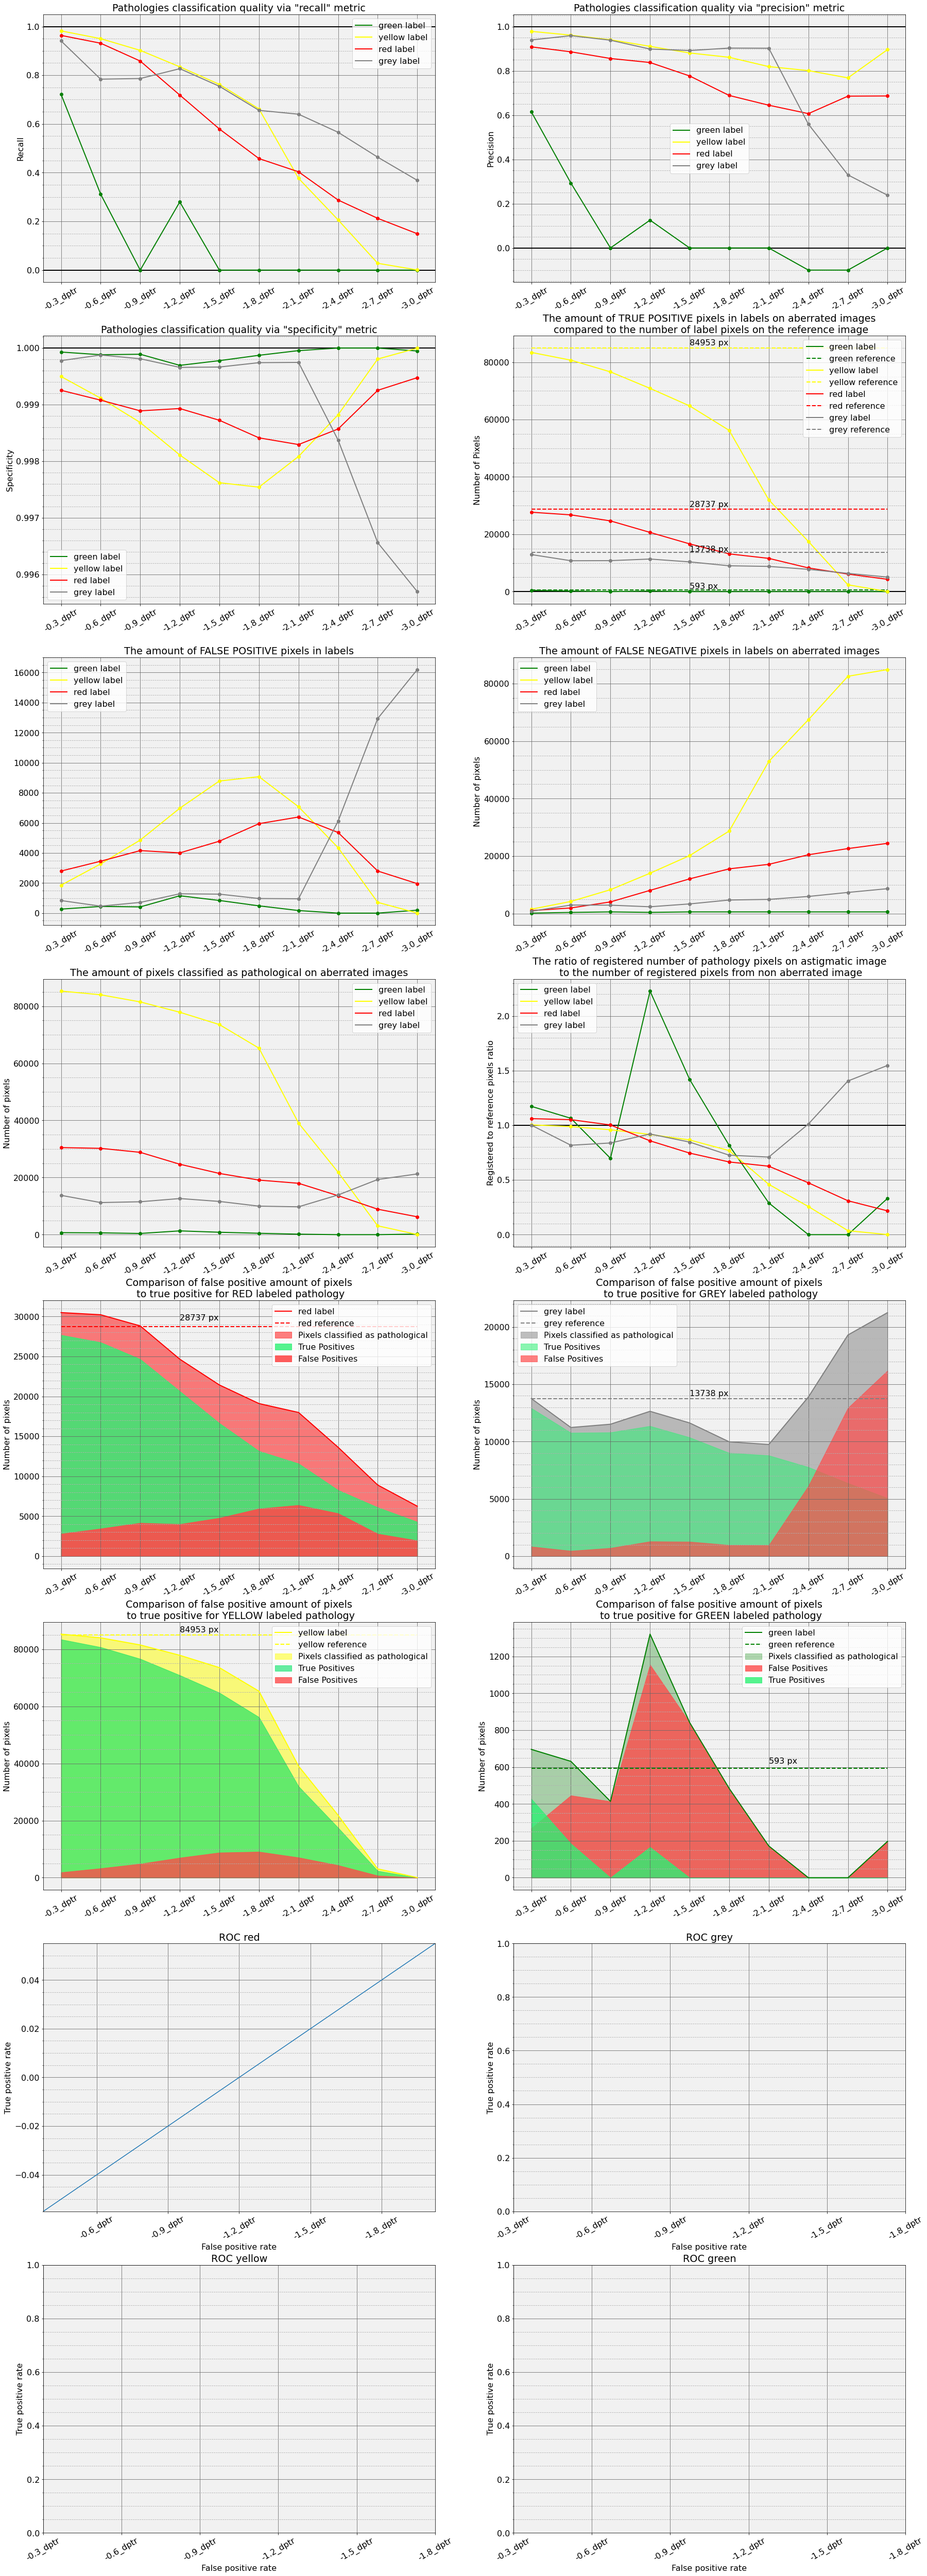

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

f = plt.figure(figsize=(30, 90))
rot_angle = 30

ax1 = f.add_subplot(821)
ax1.set_title('Pathologies classification quality via "recall" metric')
ax1.set_ylabel('Recall')
ax1.set_xticklabels(im_names, rotation = rot_angle)
ax1.grid(which = 'major', color = '#666666')
ax1.set_facecolor('#F1F1F1')
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.grid(which = 'minor', linestyle = 'dashed')
ax1.axhline(1.0, color = 'black', linewidth = 2)
ax1.axhline(0.0, color = 'black', linewidth = 2)

ax2 = f.add_subplot(822)
ax2.set_title('Pathologies classification quality via "precision" metric')
ax2.set_ylabel('Precision')
ax2.set_xticklabels(im_names, rotation = rot_angle)
ax2.grid(which = 'major', color = '#666666')
ax2.set_facecolor('#F1F1F1')
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.grid(which = 'minor', linestyle = 'dashed')
ax2.axhline(1.0, color = 'black', linewidth = 2)
ax2.axhline(0.0, color = 'black', linewidth = 2)

ax3 = f.add_subplot(823)
ax3.set_title('Pathologies classification quality via "specificity" metric')
ax3.set_ylabel('Specificity')
ax3.set_xticklabels(im_names, rotation = rot_angle)
ax3.grid(which = 'major', color = '#666666')
ax3.set_facecolor('#F1F1F1')
ax3.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax3.grid(which = 'minor', linestyle = 'dashed')
ax3.axhline(1.0, color = 'black', linewidth = 2)

ax4 = f.add_subplot(824)
ax4.set_title('The amount of TRUE POSITIVE pixels in labels on aberrated images\n compared to the number of label pixels on the reference image')
ax4.set_ylabel('Number of Pixels')
ax4.set_xticklabels(im_names, rotation = rot_angle)
ax4.grid(which = 'major', color = '#666666')
ax4.set_facecolor('#F1F1F1')
ax4.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax4.grid(which = 'minor', linestyle = 'dashed')
ax4.text(4, 86000, '84953 px')
ax4.text(4, 29500, '28737 px')
ax4.text(4, 14000, '13738 px')
ax4.text(4, 1000, '593 px')
ax4.axhline(0.0, color = 'black', linewidth = 2)
#ax4.set_yscale('log')

ax5 = f.add_subplot(825)
ax5.set_title('The amount of FALSE POSITIVE pixels in labels')
ax5.set_xticklabels(im_names, rotation = rot_angle)
ax5.grid(which = 'major', color = '#666666')
ax5.set_facecolor('#F1F1F1')
ax5.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax5.grid(which = 'minor', linestyle = 'dashed')

ax6 = f.add_subplot(826)
ax6.set_title('The amount of FALSE NEGATIVE pixels in labels on aberrated images')
ax6.set_ylabel('Number of pixels')
ax6.set_xticklabels(im_names, rotation = rot_angle)
ax6.grid(which = 'major', color = '#666666')
ax6.set_facecolor('#F1F1F1')
ax6.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax6.grid(which = 'minor', linestyle = 'dashed')

ax7 = f.add_subplot(827)
ax7.set_title('The amount of pixels classified as pathological on aberrated images')
ax7.set_ylabel('Number of pixels')
ax7.set_xticklabels(im_names, rotation = rot_angle)
ax7.grid(which = 'major', color = '#666666')
ax7.set_facecolor('#F1F1F1')
ax7.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax7.grid(which = 'minor', linestyle = 'dashed')

ax8 = f.add_subplot(828)
ax8.set_title('The ratio of registered number of pathology pixels on astigmatic image\n to the number of registered pixels from non aberrated image')
ax8.set_ylabel('Registered to reference pixels ratio')
ax8.set_xticklabels(im_names, rotation = rot_angle)
ax8.grid(which = 'major', color = '#666666')
ax8.set_facecolor('#F1F1F1')
ax8.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax8.grid(which = 'minor', linestyle = 'dashed')
ax8.axhline(1.0, color = 'black', linewidth = 2)

ax9 = f.add_subplot(829)
ax9.set_title('Comparison of false positive amount of pixels\n to true positive for RED labeled pathology')
ax9.set_ylabel('Number of pixels')
ax9.set_xticklabels(im_names, rotation = rot_angle)
ax9.grid(which = 'major', color = '#666666')
ax9.set_facecolor('#F1F1F1')
ax9.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax9.grid(which = 'minor', linestyle = 'dashed')

ax10 = f.add_subplot(8, 2, 10)
ax10.set_title('Comparison of false positive amount of pixels\n to true positive for GREY labeled pathology')
ax10.set_ylabel('Number of pixels')
ax10.set_xticklabels(im_names, rotation = rot_angle)
ax10.grid(which = 'major', color = '#666666')
ax10.set_facecolor('#F1F1F1')
ax10.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax10.grid(which = 'minor', linestyle = 'dashed')

ax11 = f.add_subplot(8, 2, 11)
ax11.set_title('Comparison of false positive amount of pixels\n to true positive for YELLOW labeled pathology')
ax11.set_ylabel('Number of pixels')
ax11.set_xticklabels(im_names, rotation = rot_angle)
ax11.grid(which = 'major', color = '#666666')
ax11.set_facecolor('#F1F1F1')
ax11.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax11.grid(which = 'minor', linestyle = 'dashed')

ax12 = f.add_subplot(8, 2, 12)
ax12.set_title('Comparison of false positive amount of pixels\n to true positive for GREEN labeled pathology')
ax12.set_ylabel('Number of pixels')
ax12.set_xticklabels(im_names, rotation = rot_angle)
ax12.grid(which = 'major', color = '#666666')
ax12.set_facecolor('#F1F1F1')
ax12.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax12.grid(which = 'minor', linestyle = 'dashed')

ax13 = f.add_subplot(8, 2, 13)
ax13.set_title('ROC red')
ax13.set_ylabel('True positive rate')
ax13.set_xlabel('False positive rate')
ax13.set_xticklabels(im_names, rotation = rot_angle)
ax13.grid(which = 'major', color = '#666666')
ax13.set_facecolor('#F1F1F1')
ax13.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax13.grid(which = 'minor', linestyle = 'dashed')
ax13.plot([0, 1], [0, 1], transform=ax13.transAxes)

ax14 = f.add_subplot(8, 2, 14)
ax14.set_title('ROC grey')
ax14.set_ylabel('True positive rate')
ax14.set_xlabel('False positive rate')
ax14.set_xticklabels(im_names, rotation = rot_angle)
ax14.grid(which = 'major', color = '#666666')
ax14.set_facecolor('#F1F1F1')
ax14.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax14.grid(which = 'minor', linestyle = 'dashed')

ax15 = f.add_subplot(8, 2, 15)
ax15.set_title('ROC yellow')
ax15.set_ylabel('True positive rate')
ax15.set_xlabel('False positive rate')
ax15.set_xticklabels(im_names, rotation = rot_angle)
ax15.grid(which = 'major', color = '#666666')
ax15.set_facecolor('#F1F1F1')
ax15.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax15.grid(which = 'minor', linestyle = 'dashed')

ax16 = f.add_subplot(8, 2, 16)
ax16.set_title('ROC green')
ax16.set_ylabel('True positive rate')
ax16.set_xlabel('False positive rate')
ax16.set_xticklabels(im_names, rotation = rot_angle)
ax16.grid(which = 'major', color = '#666666')
ax16.set_facecolor('#F1F1F1')
ax16.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax16.grid(which = 'minor', linestyle = 'dashed')

for j in range(len(colours)):

  recall = []
  precision = []
  specificity = []
  TP = []
  FP = []
  FN = []
  registered_pixels = []
  reference_pixels = []
  ratio = []

  for i in range(len(data[colours[j]])):

    recall.append(data[colours[j]][i]['Recall'])
    precision.append(data[colours[j]][i]['Precision'])
    specificity.append(data[colours[j]][i]['Specificity'])
    TP.append(data[colours[j]][i]['TP'])
    FP.append(data[colours[j]][i]['FP'])
    FN.append(data[colours[j]][i]['FN'])
    registered_pixels.append(data[colours[j]][i]['Registered_pixels'])
    reference_pixels.append(data[colours[j]][i]['Reference_pixels'])
    ratio.append(data[colours[j]][i]['Registered_pixels']/data[colours[j]][i]['Reference_pixels'])

  ax1.plot(im_names, recall, 'o', color = colours[j])
  ax1.plot(im_names, recall, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax1.legend(loc = 'upper right')

  ax2.plot(im_names, precision, 'o', color = colours[j])
  ax2.plot(im_names, precision, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax2.legend(loc = 'center')

  ax3.plot(im_names, specificity, 'o', color = colours[j])
  ax3.plot(im_names, specificity, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax3.legend(loc = 'lower left')

  ax4.plot(im_names, TP, 'o', color = colours[j])
  ax4.plot(im_names, TP, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax4.plot(im_names, reference_pixels, '--', color = colours[j], linewidth = 2, label = '{0} reference'.format(colours[j]))
  ax4.legend(loc = 'upper right')

  ax5.plot(im_names, FP, 'o', color = colours[j])
  ax5.plot(im_names, FP, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax5.legend(loc = 'upper left')

  ax6.plot(im_names, FN, 'o', color = colours[j])
  ax6.plot(im_names, FN, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax6.legend(loc = 'upper left')

  ax7.plot(im_names, registered_pixels, 'o', color = colours[j])
  ax7.plot(im_names, registered_pixels, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax7.legend(loc = 'upper right')

  ax8.plot(im_names, ratio, 'o', color = colours[j])
  ax8.plot(im_names, ratio, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
  ax8.legend(loc = 'upper left')

  if colours[j] == 'red':

    ax9.plot(im_names, registered_pixels, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
    ax9.plot(im_names, FP, color = '#FE4B4B', linewidth = 2, alpha = 0.0)
    ax9.plot(im_names, TP, color = '#2BF173', linewidth = 2, alpha = 0.0)

    ax9.fill_between(im_names, registered_pixels, color = 'red', label = 'Pixels classified as pathological', alpha = 0.5)
    ax9.fill_between(im_names, TP, color = '#2BF173', label = 'True Positives', alpha = 0.8)   
    ax9.fill_between(im_names, FP, color = '#FE4B4B', label = 'False Positives', alpha = 0.9)   

    ax9.plot(im_names, reference_pixels, '--', color = colours[j], linewidth = 2, label = '{0} reference'.format(colours[j]))
    ax9.text(3, 29500, '28737 px')
    ax9.legend(loc = 'upper right')

  if colours[j] == 'grey':

    ax10.plot(im_names, registered_pixels, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
    ax10.plot(im_names, FP, color = '#FE4B4B', linewidth = 2, alpha = 0.0)
    ax10.plot(im_names, TP, color = '#2BF173', linewidth = 2, alpha = 0.0)

    ax10.fill_between(im_names, registered_pixels, color = 'grey', label = 'Pixels classified as pathological', alpha = 0.5)
    ax10.fill_between(im_names, TP, color = '#2BF173', label = 'True Positives', alpha = 0.55)   
    ax10.fill_between(im_names, FP, color = '#FE4B4B', label = 'False Positives', alpha = 0.7)   

    ax10.plot(im_names, reference_pixels, '--', color = colours[j], linewidth = 2, label = '{0} reference'.format(colours[j]))
    ax10.text(4, 14000, '13738 px')
    ax10.legend(loc = 'upper left')

  if colours[j] == 'yellow':

    ax11.plot(im_names, registered_pixels, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
    ax11.plot(im_names, FP, color = '#FE4B4B', linewidth = 2, alpha = 0.0)
    ax11.plot(im_names, TP, color = '#2BF173', linewidth = 2, alpha = 0.0)

    ax11.fill_between(im_names, registered_pixels, color = 'yellow', label = 'Pixels classified as pathological', alpha = 0.5)
    ax11.fill_between(im_names, TP, color = '#00E263', label = 'True Positives', alpha = 0.6)   
    ax11.fill_between(im_names, FP, color = '#FE4B4B', label = 'False Positives', alpha = 0.8)   

    ax11.plot(im_names, reference_pixels, '--', color = colours[j], linewidth = 2, label = '{0} reference'.format(colours[j]))
    ax11.text(3, 86000, '84953 px')
    ax11.legend(loc = 'upper right')

  if colours[j] == 'green':

    ax12.plot(im_names, registered_pixels, color = colours[j], linewidth = 2, label = '{0} label'.format(colours[j]))
    ax12.plot(im_names, FP, color = '#FE4B4B', linewidth = 2, alpha = 0.0)
    ax12.plot(im_names, TP, color = '#2BF173', linewidth = 2, alpha = 0.0)

    ax12.fill_between(im_names, registered_pixels, color = 'green', label = 'Pixels classified as pathological', alpha = 0.3)   
    ax12.fill_between(im_names, FP, color = '#FE4B4B', label = 'False Positives', alpha = 0.8)   
    ax12.fill_between(im_names, TP, color = '#2BF173', label = 'True Positives', alpha = 0.8)

    ax12.plot(im_names, reference_pixels, '--', color = colours[j], linewidth = 2, label = '{0} reference'.format(colours[j]))
    ax12.text(6, 620, '593 px')
    ax12.legend(loc = 'upper right')

plt.show()